# Merton Jump-Diffusion Model - Implied Volatility and Probability Density

This notebook computes the implied volatility and probability density when the logarithmic asset price follows a jump-diffusion process with a normal jump size distribution. This is a sample implementation that is rather geared towards readability than efficiency.

In [2]:
import numpy
import scipy.stats as stats
import matplotlib.pyplot as pyplot
import math
%matplotlib inline

## Characteristic Functions & Cumulants

The characteristic function $\phi_{X_t}(\omega)$ and cumulants $c_{X_t}(n)$ of the Merton (1976) jump-diffusion model. The logarithmic return proces $X_t = \ln \left( S_t / S_0 \right)$ is given by

\begin{equation}
X_t = \gamma t + \sigma W_t + \sum_{i = 1}^{N_t} Y_i.
\end{equation}

Here, $N$ is a Poisson process with intensity $\eta \in \mathbb{R}_+$ and $\left( Y_i \right)_{i = 1}^\infty$ is a sequence of i.i.d. normal random variables with distribution $\mathcal{N} \left( \alpha, \beta^2 \right)$. $\gamma$ is the risk-neutral drift of the logarithmic spot price such that

\begin{equation}
\mathbb{E} \left[ e^{X_t} \right] = e^{(r - q) t},
\end{equation}

where $r$ and $q$ are the risk-free interest rate and dividend yield, respectively. We have

\begin{equation}
\gamma = r - q - \frac{1}{2} \sigma^2 - \eta \left( \phi_Y(-\mathrm{i}) - 1 \right),
\end{equation}

where $\phi_Y(\omega)$ is the characteristic function of the random jumps.

In [3]:
def characteristicNormal(omega, mu, sigma):
    phi = numpy.exp(1j * omega * mu - 0.5 * omega * omega * sigma * sigma)
    return phi

def characteristicMerton(omega, maturity, rate, dividend, volatility, eta, alpha, beta):
    phi = numpy.exp(maturity * (1j * omega * (rate - dividend - 0.5 * volatility * volatility - eta * (characteristicNormal(-1j, alpha, beta) - 1)) - 0.5 * omega * omega * volatility * volatility + eta * (characteristicNormal(omega, alpha, beta) - 1)))
    return phi

def cumulantsMerton(maturity, rate, dividend, volatility, eta, alpha, beta):
    cumulants = numpy.zeros(4)
    cumulants[0] = rate - dividend - 0.5 * volatility * volatility - eta * (characteristicNormal(-1j, alpha, beta) - 1) + eta * alpha
    cumulants[1] = volatility * volatility + eta * (alpha * alpha + beta * beta)
    cumulants[2] = eta * alpha * (alpha * alpha + 3 * beta * beta)
    cumulants[3] = eta * (alpha * alpha * alpha * alpha + 6 * alpha * alpha * beta * beta + 3 * beta * beta * beta * beta)
    cumulants = cumulants * maturity
    return cumulants

def momentsFromCumulants(cumulants):
    moments = numpy.zeros(4)
    moments[0] = cumulants[0]
    moments[1] = cumulants[1]
    moments[2] = cumulants[2] / numpy.power(cumulants[1], 1.5)
    moments[3] = cumulants[3] / numpy.power(cumulants[1], 2.0)
    return moments

## Generic European Plain Vanilla Pricer

European plain vanilla pricer using the Fang and Oosterlee (2008) Fourier cosine series method. Note that the COS method requires the characteristic function and cumulants of $Z_t = \ln \left( S_t / K \right)$. These can be expressed in terms of $\phi_{X_t}(\omega)$ and $c_{X_t}(n)$ as

\begin{equation}
\phi_{Z_t}(\omega) = e^{\mathrm{i} \omega \ln \left( S_0 / K \right)} \phi_{X_t}(\omega)
\end{equation}

and

\begin{equation}
c_{Z_t}(n) = \ln \left( S_0 / K \right) \mathrm{1} \{ n = 1 \} + c_{X_t}(n).
\end{equation}

In [4]:
def vanillaCOSMethod(phi, cumulants, maturity, strike, rate):
    N = 2**10
    
    span = numpy.sqrt(cumulants[1] + numpy.sqrt(cumulants[3]))
    a = cumulants[0] - 10.0 * span
    b = cumulants[0] + 10.0 * span
    def chiFunction(k, c, d):
        temp = k * numpy.pi / (b - a)
        result = numpy.cos(temp * (d - a)) * numpy.exp(d)
        result -= numpy.cos(temp * (c - a)) * numpy.exp(c)
        result += temp * numpy.sin(temp * (d - a)) * numpy.exp(d)
        result -= temp * numpy.sin(temp * (c - a)) * numpy.exp(c)
        result /= (1 + temp * temp)
        return result
    def psiFunction(k, c, d):
        temp = k * numpy.pi / (b - a)
        result = (numpy.sin(temp * (d - a)) - numpy.sin(temp * (c - a))) / temp
        result[k == 0] = d - c
        return result
    def vFunction(k):
        return 2 * strike * (psiFunction(k, a, 0) - chiFunction(k, a, 0)) / (b - a)
    k = numpy.arange(float(N))
    temp = k * numpy.pi / (b - a)
    elementVector = numpy.real(phi(temp) * numpy.exp(-1j * a * temp)) * vFunction(k)
    elementVector[0] *= 0.5
    price = numpy.exp(-rate * maturity) * numpy.sum(elementVector)
    return price 

def vanillaMerton(maturity, strike, isCall, spot, rate, dividend, volatility, eta, alpha, beta):
    flag = 1 if isCall else -1
    cumulants = cumulantsMerton(maturity, rate, dividend, volatility, eta, alpha, beta)
    cumulants[0] += numpy.log(spot / strike)
    adjustedPhi = lambda omega: numpy.exp(1j * omega * numpy.log(spot / strike)) * characteristicMerton(omega, maturity, rate, dividend, volatility, eta, alpha, beta)
    price = vanillaCOSMethod(adjustedPhi, cumulants, maturity, strike, rate)
    if (flag == 1):
        price += spot - strike * numpy.exp(-rate * maturity)
    return price

## Generic Implied Density Computation

We also use the COS method to compute the model implied density of $X_t$.

In [5]:
def impliedDensityCOSMethod(phi, cumulants, xValues):
    N = 2**10
    
    span = numpy.sqrt(cumulants[1] + numpy.sqrt(cumulants[3]))
    a = cumulants[0] - 10.0 * span
    b = cumulants[0] + 10.0 * span
    k = numpy.arange(float(N))
    temp = k * numpy.pi / (b - a)
    elementVector = 2.0 * numpy.real(phi(temp) * numpy.exp(-1j * temp * a)) / (b - a)
    elementVector[0] *= 0.5
    yValues = [numpy.sum(elementVector * numpy.cos(temp * (xValues[i] - a))) for i in xrange(len(xValues))]
    return yValues

def impliedDensityMerton(maturity, xValues, rate, dividend, volatility, eta, alpha, beta):
    cumulants = cumulantsMerton(maturity, rate, dividend, volatility, eta, alpha, beta)
    yValues = impliedDensityCOSMethod(lambda omega: characteristicMerton(omega, maturity, rate, dividend, volatility, eta, alpha, beta), cumulants, xValues)
    return yValues

## Black-Scholes European Plain Vanilla Pricer

Analytic European plain vanilla in the Black and Scholes (1973) model with delta, gamma and vega.

In [6]:
def vanillaBlackScholes(maturity, strike, isCall, spot, rate, dividend, volatility):
    flag = 1 if isCall else -1
    totalVolatility = volatility * numpy.sqrt(maturity)
    dPlus = (numpy.log(spot / strike) + rate - dividend + 0.5 * totalVolatility * totalVolatility) / totalVolatility
    dMinus = dPlus - totalVolatility
    delta = flag * numpy.exp(-dividend * maturity) * stats.norm.cdf(flag * dPlus)
    gamma = numpy.exp(-dividend * maturity) * stats.norm.pdf(dPlus) / (spot * totalVolatility)
    vega = gamma * spot * spot * volatility * maturity
    price = delta * spot - flag * strike * numpy.exp(-rate * maturity) * stats.norm.cdf(flag * dMinus)
    return price, delta, gamma, vega

## Implied Volatility Computation

We try to find a first guess using the Corrado and Miller (1996) approximation. If that fails, a standard starting value is used. The implied volatility is computed using a Newton algorithm.

In [7]:
def corradoMillerApproximation(maturity, strike, isCall, spot, rate, dividend, market_price):
    flag = 1.0 if isCall else -1.0
    forward = spot * numpy.exp((rate - dividend) * maturity)
    rootTwoPi = numpy.sqrt(2.0 * numpy.pi)
    a = (forward + strike) / (2.0 * rootTwoPi)
    b = 0.5 * flag * (forward - strike) - numpy.exp(rate * maturity) * market_price
    c = numpy.log(forward / strike) * (forward - strike) / rootTwoPi
    d = b * b - 4.0 * a * c
    impliedVolatility = float("NaN")
    if (d >= 0.0):
        impliedVolatility = (-b + numpy.sqrt(b * b - 4 * a * c)) / (2.0 * a)
    return impliedVolatility

def impliedVolatility(maturity, strike, isCall, spot, rate, dividend, marketPrice):
    INITIAL_GUESS = 0.2
    MAX_STEP = 0.1
    STEP_FACTOR = 0.5
    CONVERGENCE_THRESHOLD = 0.0001
    MAX_ITERATIONS = 50
    
    initialGuess = corradoMillerApproximation(maturity, strike, isCall, spot, rate, dividend, marketPrice)
    if initialGuess.imag != 0 or math.isnan(initialGuess):
        initialGuess = INITIAL_GUESS
    maxStep = numpy.min(STEP_FACTOR * initialGuess, MAX_STEP)
    isConverged = False
    impliedVolatility = initialGuess
    iterationNumber = 0
    while not isConverged and iterationNumber < MAX_ITERATIONS:
        iterationNumber = iterationNumber + 1
        price, _, _, vega = vanillaBlackScholes(maturity, strike, isCall, spot, rate, dividend, impliedVolatility)
        volatilityStep = (marketPrice - price) / vega
        if numpy.abs(volatilityStep) > maxStep:
            volatilityStep = numpy.sign(volatilityStep) * maxStep
        impliedVolatility = impliedVolatility + volatilityStep
        if numpy.abs(volatilityStep) < CONVERGENCE_THRESHOLD:
            isConverged = True
    return (impliedVolatility, isConverged)

## Plots

In [8]:
# market and model settings
maturity = 1.0 / 12.0
spot = 100.0
rate = 0.0
dividend = 0.0
volatility = 0.2
eta = 25.0
alpha = 0.0
betas = [0.0, 0.01, 0.02]

/Users/matthias/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/matthias/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in divide
/Users/matthias/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return umr_minimum(a, axis, None, out, keepdims)


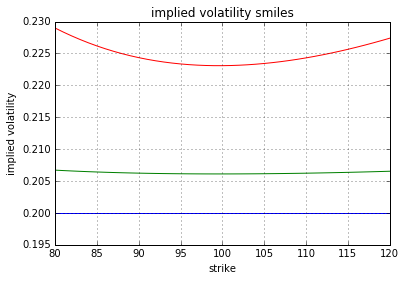

In [9]:
# plot the implied volatility smiles
strikes = numpy.linspace(80.0, 120.0, 41)
for beta in betas:
    prices = [vanillaMerton(maturity, strike, True, spot, rate, dividend, volatility, eta, alpha, beta) for strike in strikes]
    impliedVolatilities = [impliedVolatility(maturity, strike, True, spot, rate, dividend, price)[0] for (strike, price) in zip(strikes, prices)]
    pyplot.plot(strikes, impliedVolatilities)
pyplot.grid(True)
pyplot.xlabel("strike")
pyplot.ylabel("implied volatility")
pyplot.title("implied volatility smiles")
pyplot.savefig("ImpliedVolatilitySmiles.png")

/Users/matthias/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: ComplexWarning: Casting complex values to real discards the imaginary part


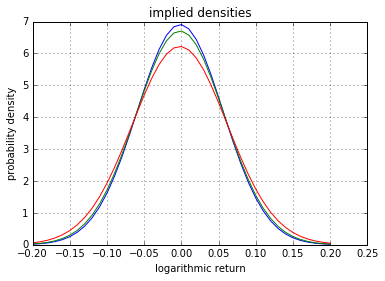

In [10]:
# plot the implied densities
returns = numpy.linspace(-0.2, 0.2, 41)
axis2 = pyplot.plot()
for beta in betas:
    densities = impliedDensityMerton(maturity, returns, rate, dividend, volatility, eta, alpha, beta)
    pyplot.plot(returns, densities)
pyplot.grid(True)
pyplot.xlabel("logarithmic return")
pyplot.ylabel("probability density")
pyplot.title("implied densities")
pyplot.savefig("ImpliedDensities.png")

/Users/matthias/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: ComplexWarning: Casting complex values to real discards the imaginary part


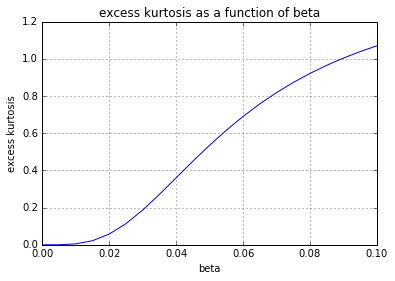

In [10]:
# plot the excess kurtosis as a function of beta
alpha = 0.0
betas = numpy.linspace(0.0, 0.1, 21)
kurtosis = [momentsFromCumulants(cumulantsMerton(maturity, rate, dividend, volatility, eta, alpha, beta))[3] for beta in betas]
pyplot.plot(betas, kurtosis)
pyplot.grid(True)
pyplot.xlim([betas[0], betas[-1]])
pyplot.xlabel("beta")
pyplot.ylabel("excess kurtosis")
pyplot.title("excess kurtosis as a function of beta")
pyplot.savefig("ExcessKurtosisJumpVolatility.png")

/Users/matthias/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: ComplexWarning: Casting complex values to real discards the imaginary part


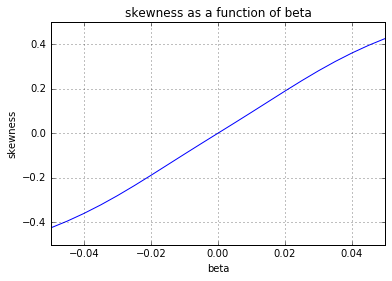

In [11]:
# plot the skewness as a function of alpha
beta = 0.02
alphas = numpy.linspace(-0.05, 0.05, 21)
skewness = [momentsFromCumulants(cumulantsMerton(maturity, rate, dividend, volatility, eta, alpha, beta))[2] for alpha in alphas]
pyplot.plot(alphas, skewness)
pyplot.grid(True)
pyplot.xlim([alphas[0], alphas[-1]])
pyplot.xlabel("beta")
pyplot.ylabel("skewness")
pyplot.title("skewness as a function of beta")
pyplot.savefig("SkewnesssJumpMean.png")